In [3]:
from __future__ import division, print_function
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [5]:
train_df = pd.read_csv('train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('test_sessions.csv', index_col='session_id')

times  = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)
train_df = train_df.sort_values(by='time1')

print(train_df.shape)
print(test_df.shape)
train_df.head()

(253561, 21)
(82797, 20)


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [6]:
sites = ['site%s' % i for i in range(1, 11)]

train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

with open(r'./site_dic.pkl', 'rb') as input_file:
  site_dict = pickle.load(input_file)

sites_dict = pd.DataFrame(
  list(site_dict.keys()),
  index=list(site_dict.values()),
  columns=['site']
)

print(u'Total sites: ', sites_dict.shape[0])
sites_dict.head()

Total sites:  48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [12]:
top_sites = pd.Series(
  train_df[sites].fillna(0).values.flatten(),
).value_counts().sort_values(ascending=False).head(5)

print(top_sites)
sites_dict.iloc[top_sites.index]

21     123776
0      122730
23      87619
782     77055
22      58258
Name: count, dtype: int64


,site
5671,www.pacajob.com
25075,www.abmecatronique.com
7104,cbv.sfr.bench.cedexis.com
39605,cid-d6bf976dfdf5d212.users.storage.live.com
32074,mathaa.epfl.ch


In [13]:
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

time_df['min'] = train_df[times].min(axis=1)
time_df['min'] = pd.to_datetime(time_df['min'])
time_df['max'] = train_df[times].max(axis=1)
time_df['max'] = pd.to_datetime(time_df['max'])

time_df['seconds'] = (time_df['max'].values - time_df['min'].values) / np.timedelta64(1, 's')
time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In [14]:
y_train = train_df['target']

full_df = pd.concat([train_df.drop('target', axis=1), test_df])

idx_split = train_df.shape[0]

print('y_train', y_train.shape)
print('train_df', train_df.shape)
print('full_df', full_df.shape)

y_train (253561,)
train_df (253561, 21)
full_df (336358, 20)


In [15]:
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [16]:
sites_flatten = full_sites.values.flatten()
full_sites_sparse = csr_matrix((
  [1] * sites_flatten.shape[0],
  sites_flatten,
  range(0, sites_flatten.shape[0] + 10, 10)
))[:, 1:]
print('sites_flatten', sites_flatten.shape)
print('full_sites_sparse', full_sites_sparse.shape)
print('Calculation Memory Size: ', full_sites_sparse.shape[0] * full_sites_sparse.shape[0] * 4)

sites_flatten (3363580,)
full_sites_sparse (336358, 48371)
Calculation Memory Size:  452546816656


In [17]:
print('{0} elements * {1} bytes = {2} bytes'.format(
  full_sites_sparse.count_nonzero(),
  4,
  full_sites_sparse.count_nonzero() * 4
))
print('Real memory size = {0} bytes'.format(full_sites_sparse.data.nbytes))

1866898 elements * 4 bytes = 7467592 bytes
Real memory size = 14935184 bytes


In [18]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
  idx = int(round(X.shape[0] * ratio))
  lr = LogisticRegression(
    C=C,
    random_state=seed,
    n_jobs=-1
  ).fit(X[:idx, :], y[:idx])
  y_pred = lr.predict_proba(X[idx:, :])[:, 1]
  score = roc_auc_score(y[idx:], y_pred)
  return score

In [19]:
%%time
X_train = full_sites_sparse[:idx_split, :]
print(get_auc_lr_valid(X_train, y_train))

0.9201155656275813
CPU times: total: 62.5 ms
Wall time: 2.25 s


In [2]:
def write_to_submission_file(predicted_labels, out_file, target='target', index_label='session_id'):
  predicted_df = pd.DataFrame(
    predicted_labels,
    index = np.arange(1, predicted_labels.shape[0] + 1),
    columns=[target]
  )
  predicted_df.to_csv(out_file, index_label=index_label)

In [21]:
%%time
lr = LogisticRegression(C=1.0, random_state=17).fit(X_train, y_train)
X_test = full_sites_sparse[idx_split:, :]
y_test = lr.predict_proba(X_test)[:, 1]
write_to_submission_file(y_test, 'baseline_sites.csv')

CPU times: total: 969 ms
Wall time: 1.33 s


In [22]:
full_new_feat = pd.DataFrame(index=full_df.index)
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)
full_new_feat.head()

,start_month
session_id,
21669,201301
54843,201301
77292,201301
114021,201301
146670,201301


In [24]:
print('full_new_feat.shape', full_new_feat.shape)
tmp = full_new_feat[['start_month']].values
print('tmp.shape', tmp.shape)
print('full_sites_sparse.shape', full_sites_sparse.shape)
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))
print(get_auc_lr_valid(X_train, y_train))

full_new_feat.shape (336358, 1)
tmp.shape (336358, 1)
full_sites_sparse.shape (336358, 48371)
0.8772004629025791


In [25]:
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))
print(get_auc_lr_valid(X_train, y_train))

0.9183907010081689


In [27]:
full_new_feat['n_unique_sites'] = (full_sites.values > 0).sum(1)
tmp = StandardScaler().fit_transform(full_new_feat[['start_month', 'n_unique_sites']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))
print('X_train.shape', X_train.shape)
print(get_auc_lr_valid(X_train, y_train))

X_train.shape (253561, 48373)
0.9170461036718209


In [28]:
full_new_feat['start_hour'] = time_df['min'].dt.hour
full_new_feat['morning'] = (full_new_feat['start_hour'] <= 11).astype(np.int32)
full_new_feat

,start_month,n_unique_sites,start_hour,morning
session_id,,,,
21669,201301,2,8,1
54843,201301,4,8,1
77292,201301,10,8,1
114021,201301,10,8,1
146670,201301,10,8,1
...,...,...,...,...
82793,201410,3,8,1
82794,201405,10,8,1
82795,201405,10,13,0


In [29]:
%%time

tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp_scaled[:idx_split,:]]))

score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.9587936846948684
CPU times: total: 141 ms
Wall time: 2.3 s


In [30]:
%%time

Cs = np.logspace(-3, 1, 10)

scores = []

for C in Cs:
  sc = get_auc_lr_valid(X_train, y_train, C=C)
  scores.append(sc)
  print(C, ' -> ', sc)

0.001  ->  0.9354606110120816
0.0027825594022071257  ->  0.9429379429155254
0.007742636826811269  ->  0.9508529067576772
0.021544346900318832  ->  0.957238649648083
0.05994842503189409  ->  0.9595290090044395
0.1668100537200059  ->  0.9609433496852793
0.46415888336127775  ->  0.9590786964576419
1.2915496650148828  ->  0.9578421862092953
3.593813663804626  ->  0.9569472975812646
10.0  ->  0.9532444090595096
CPU times: total: 172 ms
Wall time: 14.7 s


In [31]:
np.max(scores)

np.float64(0.9609433496852793)

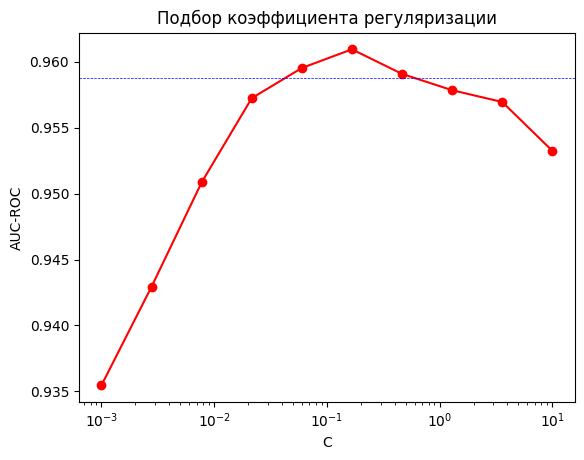

In [33]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Подбор коэффициента регуляризации')

plt.axhline(y=score_C_1, linewidth=.5, color = 'b', linestyle='dashed')
plt.show()

In [34]:
score_result = get_auc_lr_valid(X_train, y_train, C=0.1668101)
print(score_result)

0.9609433496852794


In [35]:
tmp_scaled = StandardScaler().fit_transform(
  full_new_feat[['start_month', 'start_hour', 'morning']]
)
X_train = csr_matrix(
  hstack([
    full_sites_sparse[:idx_split,:],
    tmp_scaled[:idx_split,:],
  ]),
)
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], tmp_scaled[idx_split:,:]]))
lr = LogisticRegression(C=C, random_state=17).fit(X_train, y_train)
y_test = lr.predict_proba(X_test)[:, 1]
write_to_submission_file(y_test, 'baseline_res.csv')

# Индивидуальное задание

In [3]:
# импорт данных
from __future__ import division, print_function
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

Accuracy без масштабирования: 0.7272727272727273
Accuracy с масштабированием: 0.7597402597402597
Accuracy без масштабирования c синтетическими полями: 0.7402597402597403
Accuracy с масштабированием c синтетическими полями: 0.7532467532467533
Максимальное значение C:  0.005


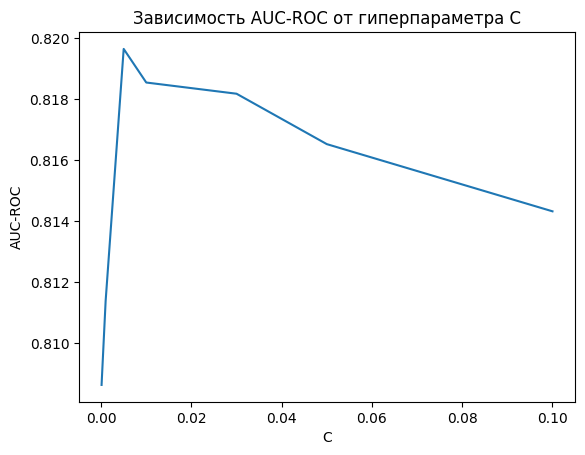

In [4]:
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # загрузка данных о людях, болеющих сахарным диабетом
    data = pd.read_csv("diabetes.csv")

    # вытаскиваем целевое поле Outcome
    X = data.drop("Outcome", axis=1)
    y = data["Outcome"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # масштабирование данных
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Без масштабирования
    model = LogisticRegression(C=0.005)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy без масштабирования:", accuracy_score(y_test, y_pred))

    # С масштабированием
    model_scaled = LogisticRegression(C=0.005)
    model_scaled.fit(X_train_scaled, y_train)
    y_pred_scaled = model_scaled.predict(X_test_scaled)
    print("Accuracy с масштабированием:", accuracy_score(y_test, y_pred_scaled))

    # Синтетические поля
    X['BMI_glucose'] = X['BMI'] * X['Glucose']
    X['age_insulin'] = X['Age'] * X['Insulin']
    X['family_history_age'] = X['DiabetesPedigreeFunction'] * X['Age']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # масштабирование данных
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Без масштабирования
    model = LogisticRegression(C=0.005)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy без масштабирования c синтетическими полями:", accuracy_score(y_test, y_pred))

    # С масштабированием
    model_scaled = LogisticRegression(C=0.005)
    model_scaled.fit(X_train_scaled, y_train)
    y_pred_scaled = model_scaled.predict(X_test_scaled)
    print("Accuracy с масштабированием c синтетическими полями:", accuracy_score(y_test, y_pred_scaled))

    C_values = [0.0001, 0.001, 0.005, 0.01, 0.03, 0.05, 0.1]
    roc_auc_scores = []

    # перебора различных значений C для нахождения наилучшего значения roc_auc
    for C in C_values:
        model = LogisticRegression(C=C)
        model.fit(X_train_scaled, y_train)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
        roc_auc_scores.append(roc_auc)

    max_C_value = C_values[roc_auc_scores.index(max(roc_auc_scores))]
    print('Максимальное значение C: ', max_C_value);
    plt.plot(C_values, roc_auc_scores)
    plt.xlabel('C')
    plt.ylabel('AUC-ROC')
    plt.title('Зависимость AUC-ROC от гиперпараметра C')
    plt.show()

    write_to_submission_file(y_pred_scaled, 'diabetes_baseline_res.csv')

#### Accuracy
- на основании точности можно сделать вывод, что с помощью синтетических полей можно улучшить точность модели
- также масштабирование зачастую положительно влияет на точность модели
#### График
- На основании данного графика можно понять, что самым лучшим значением для C является 0.005.